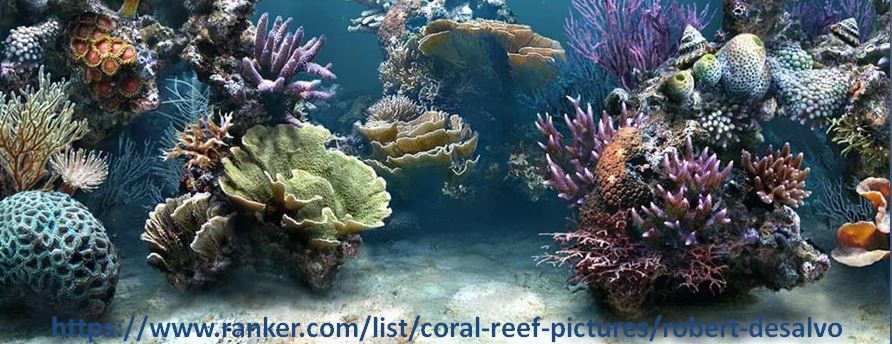

<div style="background-color: azure; padding: 10px;">
    <div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 24px;">
        <b>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Corals are distributed worldwide: from warm shallow tropical waters to the cold depths near Antarctica or the Arctic. To predict whether a certain sea bassein could be inhabited by corals, characteristics of water and seabed should be researched. The provided dataset contains the most general and basic information about sea areas. Nevertheless, this information could be useful for predicting potential corals habitats.</b>
    </div>
</div>

 <div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>1. IMPORTING MODULES<b>

In [1]:
!pip install contextily

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import contextily as cx
import matplotlib.patches as patches
import folium
from folium import Marker

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import os
import sys

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>2. MAPS WITH GEOPANDAS AND FOLIUM<b>

**Creating maps with GeoPandas and Folium makes understanding the distribution of data points much easier. These maps will be generated using both the main dataset and a smaller test set for prediction (which is the second .csv file in the 'Corals Worldwide Distribution' dataset).**

**STATIC MAP OF CORAL DISTRIBUTION IN DIFFERENT SEAS WITH GEOPANDAS:**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Read the file of the main dataset
corals = pd.read_csv("/content/drive/MyDrive/SEABED/corals_worldwide_dataset.csv")

# Create gpd object from the main dataset
corals_gpd = gpd.GeoDataFrame(
    corals,
    geometry=gpd.points_from_xy(
        corals['longitude'],
        corals['latitude']
    )
)

corals_gpd.crs={'init':'epsg:4326'}

# Differentiate coral status
corals_gpd_0 = corals_gpd[corals_gpd['corals'] == 0] # absent
corals_gpd_1 = corals_gpd[corals_gpd['corals'] == 1] # present

# corals_gpd_0.head(3)

In [5]:
# Read the test dataset and create gpd object
test_set=pd.read_csv('/content/drive/MyDrive/SEABED/corals_worldwide_test_set.csv')
test_set_gpd=gpd.GeoDataFrame(
    test_set,
    geometry=gpd.points_from_xy(
        test_set['longitude'],
        test_set['latitude']
    )
)

test_set_gpd.crs={'init':'epsg:4326'}

# Differentiate coral status
test_set_gpd_0 = test_set_gpd[test_set_gpd['coral status'] == 0] # absent
test_set_gpd_1 = test_set_gpd[test_set_gpd['coral status'] == 1] # present
test_set_gpd_2 = test_set_gpd[test_set_gpd['coral status'] == 2] # no clear information

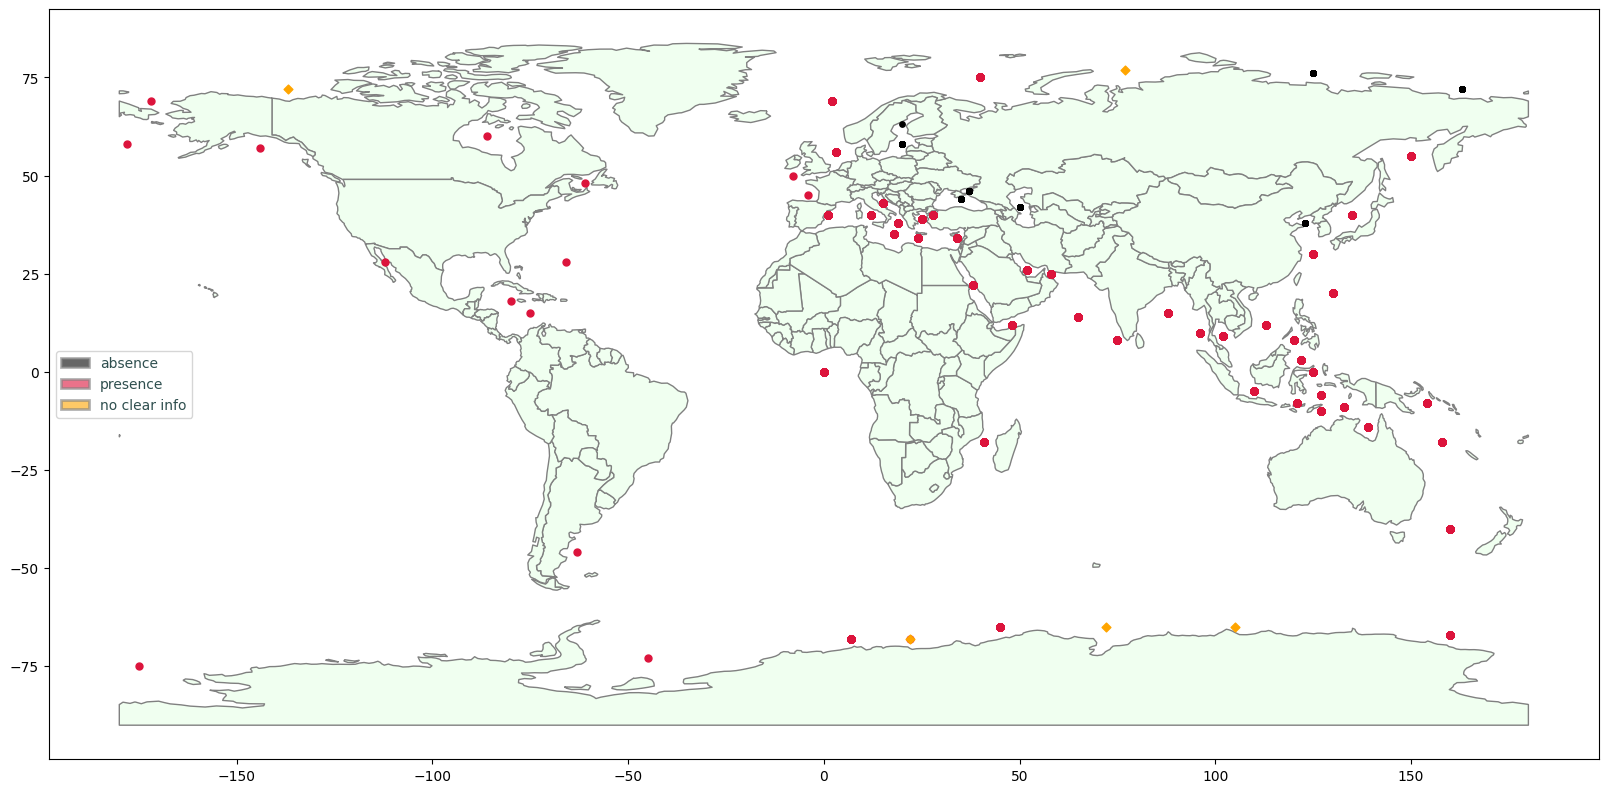

In [6]:
# Load world map info
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

import geopandas as gpd
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# Plot map and locations
ax = world.plot(figsize=(20,20), color='honeydew', edgecolor='grey', legend=True) # main map
# cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor, alpha=0.6) # color of the sea


# Add all locations with different corals status
corals_gpd_0.plot(ax=ax,  markersize = 15, marker = 'o', color='black')
corals_gpd_1.plot(ax=ax,  markersize = 25, marker = 'o', color='crimson')
test_set_gpd_0.plot(ax=ax, markersize = 15, marker = 'o', color='black')
test_set_gpd_1.plot(ax=ax,  markersize = 25, marker = 'o', color='crimson')
test_set_gpd_2.plot(ax=ax, markersize = 20, marker = 'D', color='orange')

# Create a legend
list_of_status = ['absence', 'presence','no clear info']

color_dict = {'absence':'black',
            'presence':'crimson',
            'no clear info':'orange'}

# Create patches of each color
patch_list =[]
for i in list_of_status:
    label = i
    color = color_dict[i]
    patch_list.append(patches.Patch(
        facecolor=color,
        label=label,
        alpha=0.6,
        linewidth=2,
        edgecolor='grey')
    )

# Create a legend
legend=ax.legend(handles=patch_list, fontsize=10, loc='center left')
for text in legend.get_texts():
    text.set_color('darkslategrey')

**INTERACTIVE MAP OF CORAL DISTRIBUTION IN DIFFERENT SEAS WITH FOLIUM**

In [7]:
# Function to save and show file with map in any browser (from Kaggle course on maps)
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

# Choose the colors for the markers
def color_maker(status):
    if status == 0:
        return 'purple'
    elif status == 1:
        return 'red'
    else:
        return 'orange'

# Create the map
m = folium.Map(location=[41, 12], tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}',
               attr = 'Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
               zoom_start=4)

tooltip = "Click!"

# Add markers with colors - from the main dataset
for _, row in corals_gpd.iterrows():
    status = row['corals']
    color = color_maker(status)
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
        '{}, salinity: {:.2f} PSU, silt/sulfide: {}, area: {} sq km, '
        'January temperature: {:.2f}°C, June temperature: {:.2f}°C'
        .format(
            row['name'],
            row['salinity'],
            row['silt/sulfide'],
            row['area'],
            row['January_temp'],
            row['June_temp']
            )
        ),
        icon=folium.Icon(icon = 'sun', prefix='fa', color=color),
        tooltip=tooltip
    ).add_to(m)


 # Add markers with colors - from the test dataset
for _, row in test_set_gpd.iterrows():
    status = row['coral status']
    color = color_maker(status)
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(
            '{}, salinity: {:.2f} PSU, silt/sulfide: {}, area: {} sq km, '
            'January temperature: {:.2f}°C, June temperature: {:.2f}°C'
            .format(
                row['name'],
                row['salinity'],
                row['silt/sulfide'],
                row['area'],
                row['January_temp'],
                row['June_temp']
            )
        ),
        icon=folium.Icon(icon = 'sun', prefix='fa', color=color),
        tooltip=tooltip
    ).add_to(m)

# Create a legend
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 160px; height: 100px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 opacity: 0.8;
                 ">

        <p><b><i class="fa fa-map-marker fa-1x" style="color: purple"></i> - No corals<b></p>
        <p><i class="fa fa-map-marker fa-1x" style="color: red"></i> - Corals present</p>
        <p><i class="fa fa-map-marker fa-1x" style="color: orange"></i> - No clear info</p>
    </div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# Save and display the map
embed_map(m, 'map.html')

 <div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>3. EXPLORATORY DATA ANALYSIS<b>

In [8]:
# Read the file of the main dataset
corals = pd.read_csv("/content/drive/MyDrive/SEABED/corals_worldwide_dataset.csv")
corals.head()

,name,salinity,January_temp,June_temp,area,latitude,longitude,type of sea,corals,silt/sulfide
0,Adriatic Sea,38.298527,15.658799,20.855299,138000,43,15,2,1,0
1,Adriatic Sea,38.304909,16.297098,19.501200,138000,43,15,2,1,0
2,Adriatic Sea,38.462040,16.251598,19.028500,138000,43,15,2,1,0
3,Adriatic Sea,38.121601,15.709500,22.882999,138000,43,15,2,1,0
4,Adriatic Sea,38.519196,15.733400,21.824799,138000,43,15,2,1,0


In [9]:
# Count the number of sea basseins used in dataset
unique_values = len(corals['name'].unique())
print(f'Number of seas used in dataset: {unique_values}')

Number of seas used in dataset: 51


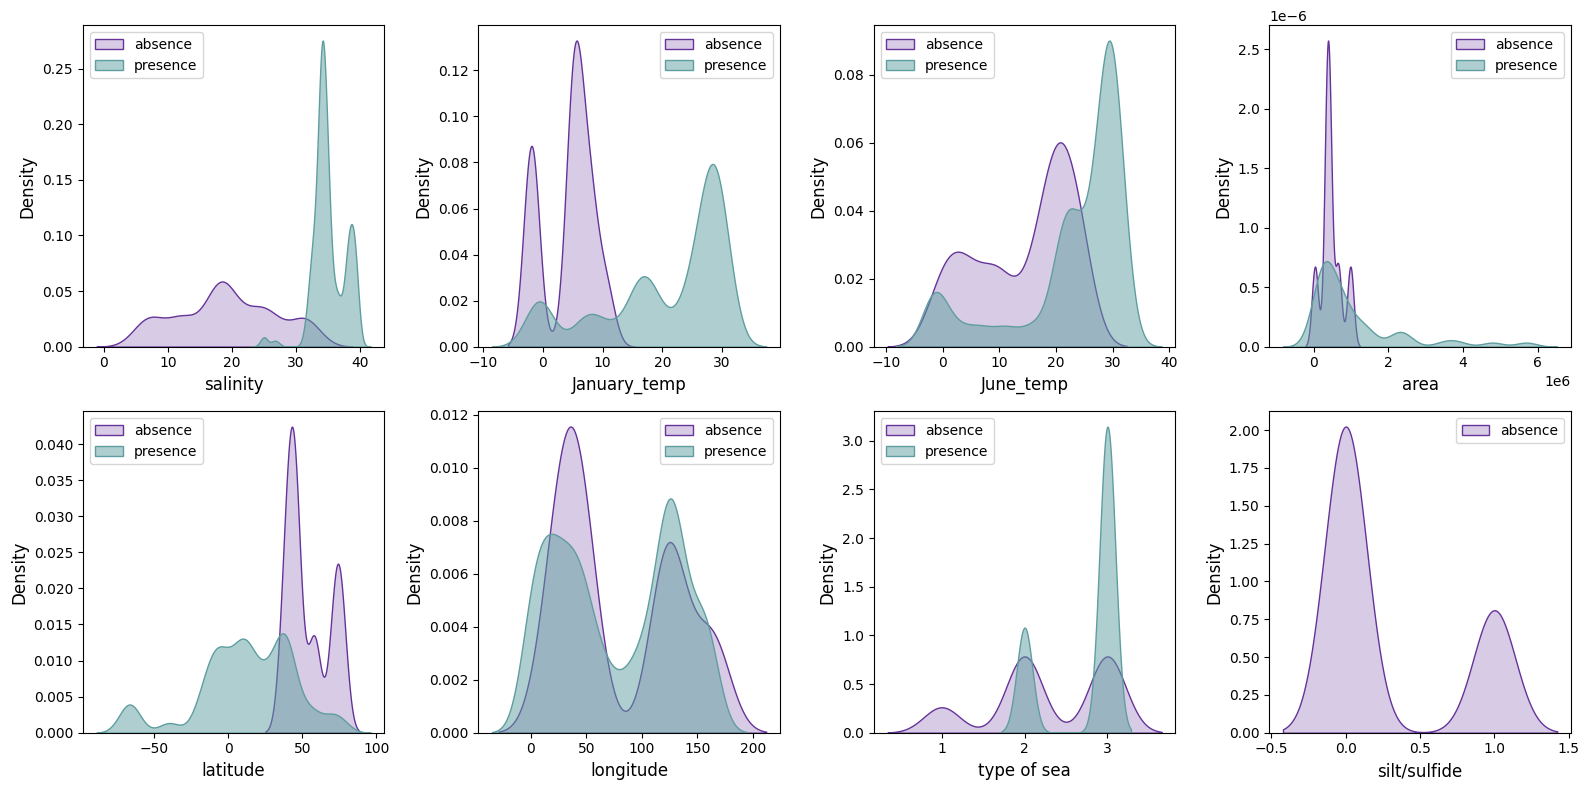

In [10]:
# Create plots describing relationship between the presence or absence of corals and other features

# Create two datasets for '1' or '0'
corals_0 = corals[corals['corals'] == 0]
corals_1 = corals[corals['corals'] == 1]

# Plot the needed kde
columns = [
    'salinity',
    'January_temp',
    'June_temp',
    'area',
    'latitude',
    'longitude',
    'type of sea',
    'silt/sulfide'
]

# Create a grid of subplots
num_plots = len(columns)
num_rows = num_plots // 4 + (num_plots % 4 > 0)
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, num_rows*4))

# Iterate over each column and create KDE plot
for i, column in enumerate(columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax = sns.kdeplot(
        corals_0[column],
        color='rebeccapurple',
        label='absence',
        fill=True,
        ax=ax,
        warn_singular=False
    )

    ax = sns.kdeplot(
        corals_1[column],
        color='cadetblue',
        alpha=0.5,
        label='presence',
        fill=True,
        ax=ax,
        warn_singular=False
    )

    ax.legend()
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)

# Remove empty subplots
if num_plots < num_rows * 4:
    for i in range(num_plots, num_rows * 4):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()

<b>By analyzing KDE plots, we can observe the following trends:
    
* Salinity emerges as the most crucial factor in differentiating areas suitable for coral habitation from those where corals cannot thrive. This observation is supported not only by our dataset but also by scientific research, which highlights salinity as a critical factor for coral survival, particularly during times of global warming;
* The presence of silt or sulfide on the sea bottom or in the water makes coral existence impossible. This phenomenon is evident, for example, in the case of the Yellow Sea, where water is heavily laden with silt from rivers. Therefore, silt or sulfide content is a significant feature that characterizes only 'non-coral' areas;
* Enclosed landlocked seas mentioned in this dataset are not the dwellings for corals;
* Surprizingly, both January temperature and latitude (!) can play a role in distinguishing between 'coral' and 'non-coral' seas.<b>

**Heat map below shows the same relations between features as we suggested from kde plots but in numeric correlations:**
* Correlation between the presence/absence of corals and salinity is the highest: 0.83
* in case of January temperatures: 0.5
* silt/sulfide: -0.51
* latitude: -0.43

<Axes: >

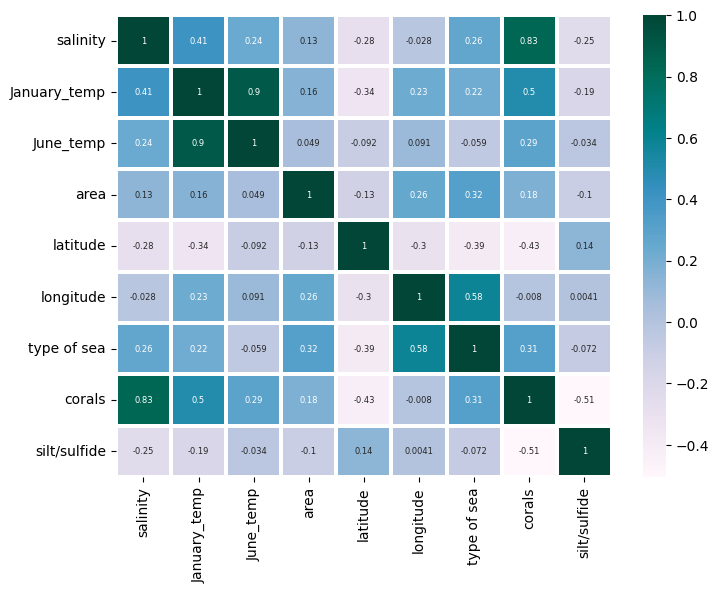

In [11]:
# Calculate correlations
corr = corals.corr(numeric_only=True)

# Set the font size
annot_font_size = 6

# Create heat map
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, linewidths=1.5, cmap="PuBuGn", annot_kws={"size": annot_font_size})

**From the barplot below we can see that the dataset is imbalanced:**

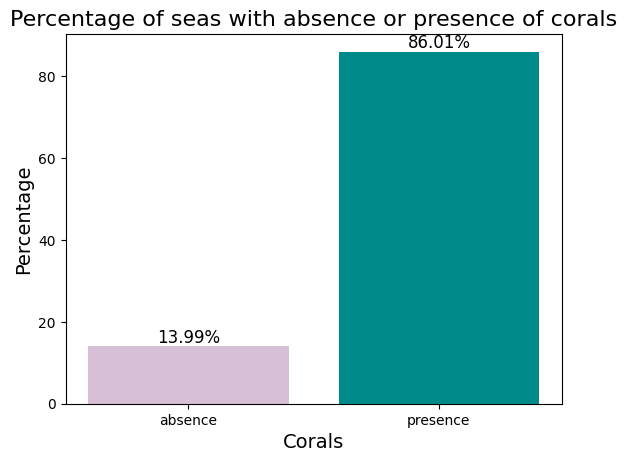

In [12]:
# Calculate value counts with normalization
value_counts = corals['corals'].value_counts(normalize=True)

# Access the percentage of 0s and 1s
percentage_0 = value_counts[0] * 100
percentage_1 = value_counts[1] * 100

# Define the data
categories = ['absence', 'presence']
percentages = [percentage_0, percentage_1]

# Define the colors for the bars
colors = ['thistle', 'darkcyan']

# Create the bar plot
plt.bar(categories, percentages, color=colors)

# Set plot title and labels
plt.title('Percentage of seas with absence or presence of corals', fontsize=16)
plt.xlabel('Corals', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Add percentage values above the bars
for i, val in enumerate(percentages):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=12)

**When distinguishing the most important features by type ('coral' or 'non-coral'), it becomes evident that**:
* 'non-coral' areas are characterized by narrow range of January temperatures and low salinity in majority of cases;
* in contrast, areas inhabited by corals show wide range of January temperatures and salinity not less than 24-25 PSU.

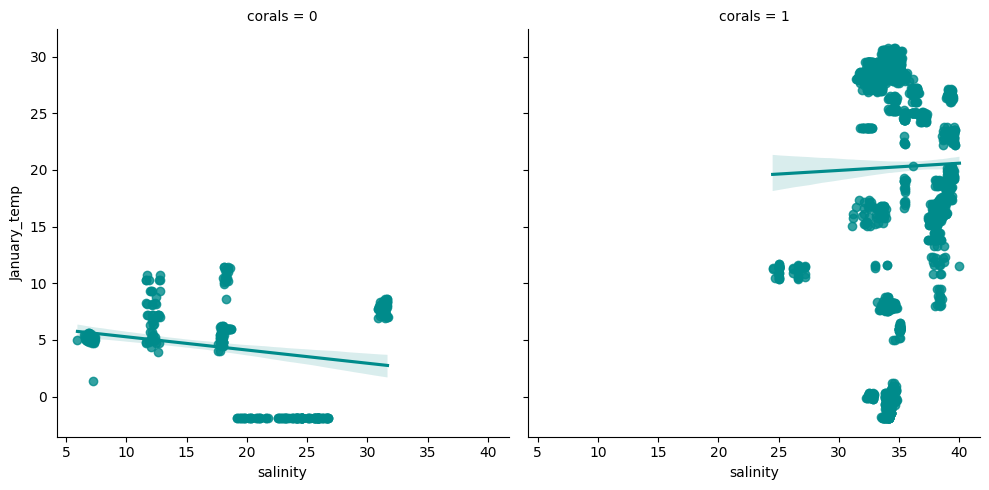

In [13]:
# Distinguish by type

# Specify a custom color palette
custom_palette = ['darkcyan']

# Set the custom palette
sns.set_palette(custom_palette)

# Create lmplots
sns.lmplot(x="salinity", y="January_temp", col="corals", data=corals);

**Investigation of violin plots:**
* Highligthed the same characteristics of the main features, plus showed us the imbalanced data on latitude.
* June temperatures were not too much different in 'coral' and 'non-coral' areas, the same as longitide.
* But as for the area - bigger water basseins had more chances to be coral dwellings.

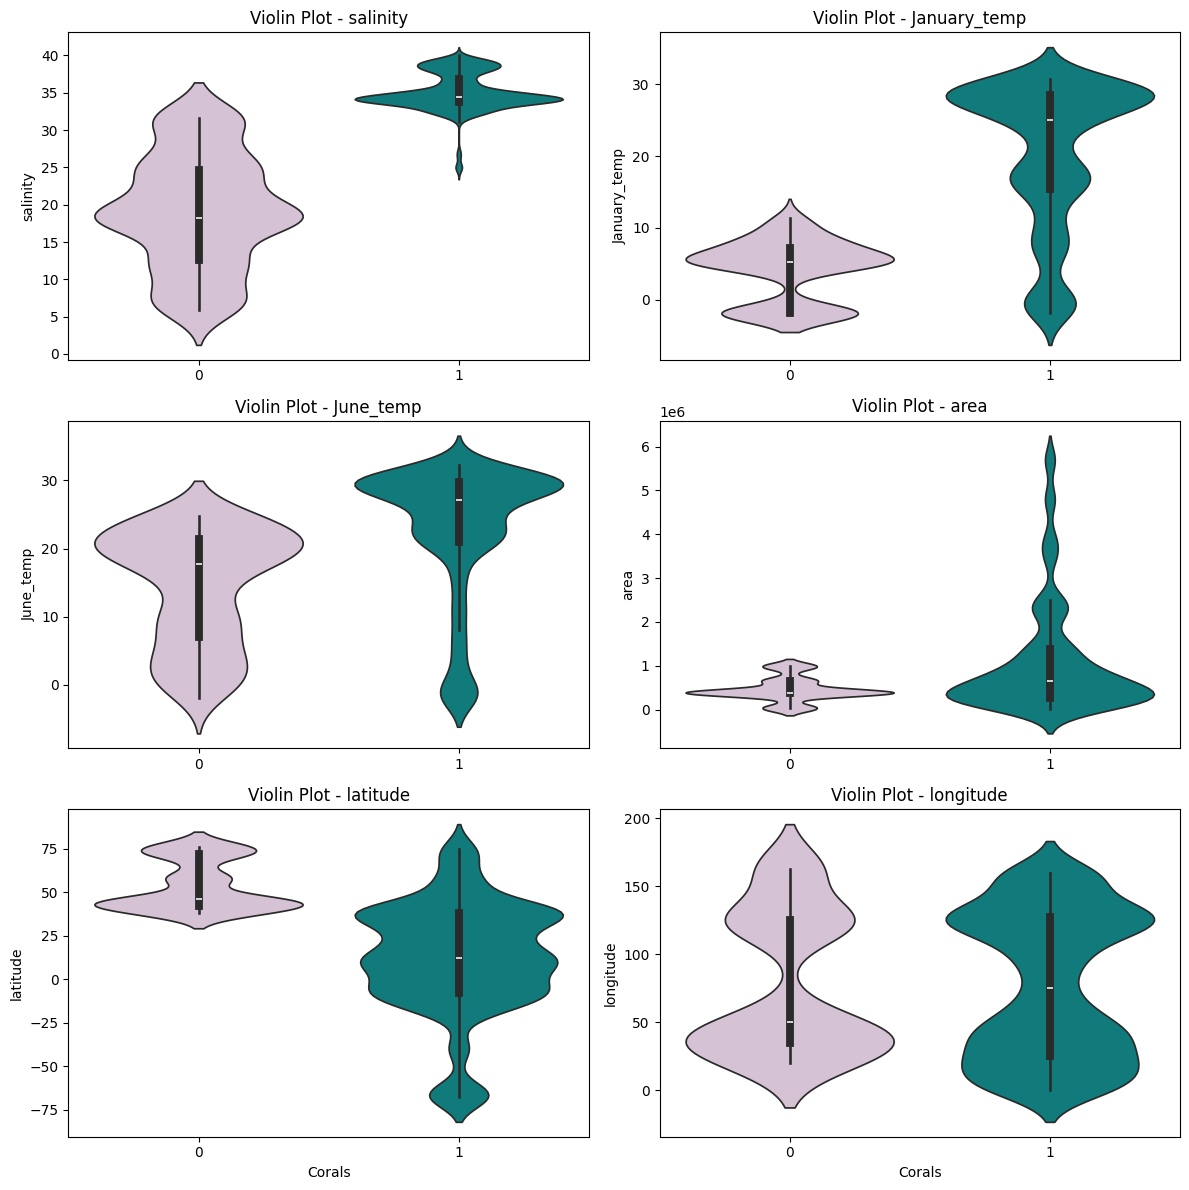

In [14]:
# Specify the columns for box plots
columns = [
    'salinity',
    'January_temp',
    'June_temp',
     'area',
    'latitude',
    'longitude'
]

# Calculate the number of rows and columns for the subplot grid
num_rows = 3
num_cols = 2
total_plots = num_rows * num_cols

# Create a figure and axes for the box plots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12))

# Iterate over each column and create the box plot
for i, column in enumerate(columns):
    if i < total_plots:
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        sns.violinplot(
            x="corals",
            y=column,
            data=corals,
            ax=ax,
            palette=['thistle', 'darkcyan']
        )

        ax.set_title('Violin Plot - ' + column)
        ax.set_xlabel('Corals')
        ax.set_ylabel(column)

        # Remove x-axis label for all but the bottom row
        if row != num_rows - 1:
            ax.set_xlabel('')
    else:
        ax.axis('off')

plt.tight_layout()

<div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>4. EDA WITH SWEETVIZ (THE VARIANT WHICH IS REALLY FAST)<b>

**Sweetviz produces a HTML file (see output for this notebook) just in several seconds. This file will contain the general information about values of each column in dataset and their correlations.**
Categorical and numerical associations could be easily distinguished on the sweetviz's heat map.

In [15]:
!pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 42.7 MB/s eta 0:00:00


In [16]:
import sweetviz as sv

# Create a report
my_report = sv.analyze(corals)

                                             |          | [  0%]   00:00 -> (? left)

In [17]:
# Save report as a HTML file
my_report.show_html('corals.html')

Report corals.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**The screenshots of the file is below:**

![barplots.JPG](attachment:dd3b84e6-bc17-4e2b-ac1e-b39c61c78e73.JPG)

![associations.JPG](attachment:61f55aad-656b-4c15-a205-cf104bd35686.JPG)

 <div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>5. SELECTING OPTIMAL CLASSIFICATION MODELS THROUGH MANUAL MODEL EVALUATION <b>

In [18]:
# Separate the data
X = corals.drop(['name', 'corals'], axis=1)
y = corals['corals']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [19]:
# Scale the input data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

**Select models one by one, evaluate metrics, and create the df with all metrics:**

In [20]:
# Define models in a list to cycle over them and create a dict with all metrics
models = [
    ('Logistic Regression', LogisticRegression(max_iter = 3000)),
    ('Decision Tree Classifier', DecisionTreeClassifier()),
    ('Random Forest Classifier', RandomForestClassifier()),
    ('SVC', SVC()),
    ('XGBoost Classifier', XGBClassifier()),
    ('LGBMClassifier', LGBMClassifier()),
    ('Gradient Boosting Classifier', GradientBoostingClassifier()),
    ('Ridge Classifier', RidgeClassifier()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('AdaBoost Classifier', AdaBoostClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Extra Trees Classifier', ExtraTreesClassifier()),
    ('Linear Discriminant Analysis', LinearDiscriminantAnalysis())
]

# Define metrics for cross-validation
cross_val_metrics = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# Create an empty list to store the results for each model
results = []

# Loop over each model
for name, model in models:
    model_results = {
        'model': name
    }

    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)

    # Perform cross-validation with metrics
    cross_val_scores = cross_validate(
        model,
        X_train_scaled,
        y_train,
        cv=5,
        scoring=cross_val_metrics
    )

    # Calculate mean scores for cross-validation metrics
    for metric in cross_val_metrics:
        key = 'test_' + metric
        model_results[metric] = cross_val_scores[key].mean()

    # Append the results for this model to the list
    results.append(model_results)

# Create a df from the results list
df_metrics = pd.DataFrame(results)

# Remove the 'test_' prefix from column names
df_metrics.columns = df_metrics.columns.str.replace('test_', '')

df_metrics

AttributeError: 'super' object has no attribute '__sklearn_tags__'

**Plots of feature importances show how 'close-to-reality' was the choice of models preferenced features:**

In [ ]:
# Create a list of models
models = [
    LogisticRegression(max_iter = 3000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    ExtraTreesClassifier()
]

# Determine the number of rows and columns for subplots based on the number of models
num_models = len(models)
num_rows = int(np.ceil(num_models / 2))
num_cols = 2 if num_models > 1 else 1

# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(22, 20))

# Iterate over each model and plot feature importances
for i, model in enumerate(models):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    model.fit(X_train_scaled, y_train)
    feature_importances = (
    np.abs(model.coef_[0]) if isinstance(model, LogisticRegression) else model.feature_importances_
)
    sorted_indices = np.argsort(feature_importances)[::-1]
    sorted_importances = feature_importances[sorted_indices]
    feature_names = X.columns

    ax.bar(range(
        len(feature_importances)),
           sorted_importances,
           tick_label = feature_names[sorted_indices],
           color='cadetblue', alpha=0.5
          )

    ax.set_xticks(range(len(feature_importances)))
    ax.set_xticklabels(feature_names[sorted_indices], rotation=90, fontsize=16)
    ax.set_title(f'{model.__class__.__name__}', fontsize=18)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.tick_params(axis='y', labelsize=12)
    # Change the color of the frame
    frame_color = 'slategray'
    for spine in ax.spines.values():
        spine.set_edgecolor(frame_color)

# Remove any unused subplots
if num_models < num_rows * num_cols:
    for i in range(num_models, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Add figure title
fig.suptitle('Feature Importances', fontsize=22, y=1)

plt.tight_layout()

**If to compare features importances selected by different models, LogisticRegression and ExtraTreesClassifier with the most important salinity and silt/sulfide bottom characteristics seem to be the most appropriate for this dataset.**

<div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>6. PREDICTIONS USING MANUALLY EVALUATED MODELS<b>

**To make predictions, I selected the data points from sea areas where corals certainly dwell or non dwell, and also areas with absent information about corals. The last - is the most interesting part of the work, because it gives possibility to predict the chances of corals survival in certain areas. It would be very useful to know such chances before organizing expeditions to search corals in these places. The pictures below are own plots built in PowerBi:**

![absent.JPG](attachment:d73e1d82-26ff-444e-9284-a1ee4f56c36b.JPG)

In [ ]:
# Make predictions on test data points
models = [
    LogisticRegression(max_iter=3000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    SVC(),
    XGBClassifier(),
    LGBMClassifier(),
    GradientBoostingClassifier(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    ExtraTreesClassifier(),
    LinearDiscriminantAnalysis()
]

# I use datapoints instead of test set df so I can easily monitor the 'no clear info' status,
# but you can use the test df: /kaggle/input/corals-worldwide-distribution/corals_worldwide_test_set.csv

# List of data points (test set) for prediction:
data_points = [
    [35.9, 26.60, 28.60, 2754000, 15, -75, 3, 0],# Carribean sea - corals presence
    [36.5, 27.30, 28.10, 4200000, 18, -80, 3, 0],# American Mediterranean Sea - corals presence
    [34.23, 22.90, 7.90, 1000000, -46, -63, 3, 0],# Argentine Sea - corals presence
    [31.6, -1.8, 10.2, 2000000, 58, -178, 3, 0],# Bering Sea - corals presence,
    [34.76, -1.8, 6.0, 620000, 69, -172, 3, 0],# Chukchi Sea - corals presence,
    [34.5, -0.8, -1.8, 637000, -75, -175, 3, 0],# Ross sea - corals presence,
    [34.65, -0.63, -1.8, 2800000, -73, -45, 3, 0],# Weddell Sea - corals presence,
    [33.76, 2.6, 12.5, 1533000, 57, -144, 3, 0],# Gulf of Alaska - corals presence,
    [35.61, 16.3, 28.6, 160000, 28, -112, 2, 0],# Gulf of California - corals presence,
    [33.52, -1.7, 15.1, 226000, 48, -61, 2, 0],# Gulf of Saint Lawrence - corals presence,
    [34.51, -1.8, 11.6, 1230000, 60, -86, 2, 0],# Hudson Bay - corals presence,
    [35.61, 20.1, 29.1, 3500000, 28, -66, 4, 0],# Sargasso Sea - corals presence,
    [35.6, 9.1, 20.3, 223000, 45, -4, 3, 0],# Bay of Biscay - corals presence,
    [33.53, 7.5, 19.6, 300000, 50, -8, 3, 0],# Celtic Sea - corals presence,
    [8.0, -1.2, 17.4, 117000, 63, 20, 2, 0],# Gulf of Bothnia - corals absence,
    [30.0, -1.8, -1.4, 476000, 72, -137, 3, 0],# Beaufort Sea - no clear info,
    [33.62, 0.12, -1.89, 258000, -65, 72, 3, 0],# Cooperation Sea - no clear info,
    [27.76, -1.89, 6.9, 926000, 77, 77, 3, 0],# Kara Sea - no clear info,
    [33.98, -1.5, -1.89, 333000, -65, 105, 3, 0],# Mawson Sea - no clear info,
    [33.99, 0.16, -1.89, 1138000, -68, 22, 3, 0]# Riiser-Larsen Sea - no clear info,
]

# Scale the data points

scaled_data_points = scaler.transform(data_points)

# Sea names with the information about corals:
sea_names = [
    "Carribean sea/presence",
    "American Mediterranean Sea/presence",
    "Argentine Sea/presence",
    "Bering Sea/presence",
    "Chukchi Sea/presence",
    "Ross sea/presence",
    "Weddell Sea/presence",
    "Gulf of Alaska/presence",
    "Gulf of California/presence",
    "Gulf of Saint Lawrence/presence",
    "Hudson Bay/presence",
    "Sargasso Sea/presence",
    "Bay of Biscay/presence",
    "Celtic Sea/presence",
    "Gulf of Bothnia/absence",
    "Beaufort Sea/no clear info",
    "Cooperation Sea/no clear info",
    "Kara Sea/no clear info",
    "Mawson Sea/no clear info",
    "Riiser-Larsen Sea/no clear info"
]

# Create an empty list to store the predictions
predictions = []

# Iterate over each data point and corresponding sea name
for scaled_data_point, data_point, sea_name in zip(scaled_data_points, data_points, sea_names):

    # Prepare the data point for prediction with matching column names
    data_point_df = pd.DataFrame([scaled_data_point], columns=X_train.columns)

    # Make the prediction
    prediction = model.predict(data_point_df)

    # Convert class label to "absence" or "presence"
    class_labels = ['absence', 'presence']
    predicted_label = class_labels[prediction[0]]

    # Store the predicted label, data point, and sea name in the predictions list
    predictions.append({'Model': type(model).__name__, 'Data Point': data_point,
                        'Sea Name/Corals Status': sea_name, 'Corals Predicted': predicted_label})

# Create an empty list to store the predictions
predictions = []

# Iterate over each model
for model in models:
    model.fit(X_train_scaled, y_train)

    # Scale the data points for each model
    scaled_data_points = scaler.transform(data_points)

    # Iterate over each scaled data point and corresponding sea name
    for scaled_data_point, data_point, sea_name in zip(scaled_data_points, data_points, sea_names):
        # Prepare the data point for prediction with matching column names
        data_point_df = pd.DataFrame([scaled_data_point], columns=X_train.columns)

        # Make the prediction
        prediction = model.predict(data_point_df)

        # Convert class label to "absence" or "presence"
        class_labels = ['absence', 'presence']
        predicted_label = class_labels[prediction[0]]

        # Store the predicted label, data point, and sea name in the predictions list
        predictions.append({'Model': type(model).__name__, 'Data Point': data_point,
                            'Sea Name/Corals Status': sea_name, 'Corals Predicted': predicted_label})

# Create a df from the predictions list
predictions_df = pd.DataFrame(predictions)
predictions_df

# Create a df from the predictions list
predictions_df = pd.DataFrame(predictions)

predictions_df.head()

In [ ]:
# Prepare more consize df for prediction results:

# Extract latitude and longitude from "Data Point" column
predictions_df['Latitude'] = predictions_df['Data Point'].apply(lambda x: x[4])
predictions_df['Longitude'] = predictions_df['Data Point'].apply(lambda x: x[5])

# Split the column by '/'
predictions_df[
    ['Sea', 'Coral Status']] = predictions_df[
    'Sea Name/Corals Status'].str.split('/', expand=True
                                       )

# Drop the original column
predictions_df = predictions_df.drop('Sea Name/Corals Status', axis=1)

# Pivot the df
# Convert lists in 'Data Point' column to tuples
# predictions_df['Data Point'] = predictions_df['Data Point'].apply(tuple)

# Pivot the df
pivot_df = predictions_df.pivot_table(
    index=['Sea',
           'Coral Status' ],
    columns='Model',
    values='Corals Predicted',
    aggfunc='first'
)

In [ ]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the entire df
pivot_df

**We have gathered a substantial amount of information to compare and consider:**


* First, we will examine the models whose feature importances closely align with the evaluation of coral dwelling in a manner that is most reflective of reality. These models include Logistic Regression and Extra Trees Classifier. Both Logistic Regression and Extra Trees Classifier correctly predicted the absence of corals in the Gulf of Bothnia and the presence of corals in all other data points. Additionally, they both categorized areas with 'no clear information' as 'presence' of corals, except for the Beaufort Sea and Kara Sea. For the Kara Sea, both Logistic Regression and Extra Trees Classifier predicted the absence of corals, while for the Beaufort Sea, Extra Trees Classifier predicted presence, and Logistic Regression predicted the absence of corals.

* As for the other classifiers, they can be divided into two groups: those that successfully predicted all known data points from the test set and those that failed to do so. Classifiers that were not suitable for this dataset include AdaBoost Classifier, Decision Tree Classifier, Gradient Boosting Classifier, LGBM Classifier, and XGB Classifier.

* Classifiers with successful predictions were Logistic Regression, Extra Trees Classifier, Ridge Classifier, K-Nearest Neighbors Classifier, Random Forest Classifier, Support Vector Classifier (SVC), Gaussian Naive Bayes (GaussianNB), and Linear Discriminant Analysis (LDA).

**Now, for the areas with unclear information:**

* Cooperation Sea: All classifiers predicted the presence of corals.

* Mawson Sea: All classifiers predicted the presence of corals.

* Riiser-Larsen Sea: All classifiers predicted the presence of corals.

* Kara Sea: Different suitable classifiers predicted 'presence' or 'absence' status in a 23% to 77% ratio.

* Beaufort Sea: Different classifiers predicted 'presence' or 'absence' status in a 54% and 46% ratio, respectively. To correctly predict all unclear variants, further tuning of the models is required.

 <div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>7. TUNING WITH FLAML <b>

![flaml.JPG](attachment:ddc0ecba-61e1-4916-9b51-407c153d4119.JPG)

**Now we can tune the models which were the most efficient in the manual selection - LogisticRegression and ExtraTreesClassifier.**

In [ ]:
!pip install FLAML

In [ ]:
from flaml import AutoML

**I will turn off any output of FLAML tuning, because it takes too much space of the file. Instead, in the next cell I will input the ready model tuned by FLAML:**

In [ ]:
# Save the original standard output
original_stdout = sys.stdout

# Redirect the standard output to a null device
sys.stdout = open(os.devnull, 'w')

# Initialize
automl = AutoML()

# Settings including time budget
settings = {
    "time_budget": 1800,  # total running time in seconds
    "metric": 'roc_auc',
    "estimator_list": ['lrl1'],  #  build-in ML learner - LogisticRegression
    "task": 'classification',
    "seed": 7654321,
    "n_splits": 5
}

automl.fit(X_train=X_train_scaled, y_train=y_train, **settings)

# Restore the original standard output
sys.stdout = original_stdout

**Predictions with the tuned LogisticRegression model:**

In [ ]:
# Create an empty list to store the predictions
predictions = []

# Iterate over each scaled data point and corresponding sea name
for scaled_data_point, data_point, sea_name in zip(scaled_data_points, data_points, sea_names):
    # Prepare the data point for prediction with matching column names
    data_point_df = pd.DataFrame([scaled_data_point], columns=X_train.columns)

    # Model tuned:
    lr=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

    lr.fit(X_train_scaled, y_train)

    # Make the prediction
    prediction = lr.predict(data_point_df)

    # Convert class label to "absence" or "presence"
    class_labels = ['absence', 'presence']
    predicted_label = class_labels[prediction[0]]

     # Store the predicted label, data point, and sea name in the predictions list
    predictions.append({'Model': type(lr).__name__, 'Data Point': data_point,
                            'Sea Name/Corals Status': sea_name, 'Corals Predicted': predicted_label})

# Create a df from the predictions list
predictions_df = pd.DataFrame(predictions)
predictions_df

In [ ]:
# Settings including time budget
settings = {
    "time_budget": 90,  # total running time in seconds
    "metric": 'roc_auc',
    "estimator_list": ['extra_tree'],  #  build-in ML learner - ExtraTreesClassifier
    "task": 'classification',
    "seed": 7654321,
    "n_splits": 5
}

# Fit the models
automl.fit(X_train=X_train_scaled, y_train=y_train, **settings)

**Predictions with the tuned ExtraTreesClassifier:**

In [ ]:
# Create an empty list to store the predictions
predictions = []

# Iterate over each scaled data point and corresponding sea name
for scaled_data_point, data_point, sea_name in zip(scaled_data_points, data_points, sea_names):
    # Prepare the data point for prediction with matching column names
    data_point_df = pd.DataFrame([scaled_data_point], columns=X_train.columns)

    # Model tuned
    et=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None,
                     max_features=0.3270198685052404, max_leaf_nodes=4,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
                     oob_score=False, random_state=12032022, verbose=0,
                     warm_start=False)

    et.fit(X_train_scaled, y_train)

    # Make the prediction
    prediction = et.predict(data_point_df)

    # Convert class label to "absence" or "presence"
    class_labels = ['absence', 'presence']
    predicted_label = class_labels[prediction[0]]

     # Store the predicted label, data point, and sea name in the predictions list
    predictions.append({'Model': type(et).__name__, 'Data Point': data_point,
                            'Sea Name/Corals Status': sea_name, 'Corals Predicted': predicted_label})

# Create a df from the predictions list
predictions_df = pd.DataFrame(predictions)
predictions_df

**LogisticRegression model and ExtraTreesClassifier tuned with the FLAML predicted the presence of corals in Kara Sea, whereas the models with default parameters predicted absence. Consequently, the Kara Sea stands out as the most intriguing area among those investigated...**

<div style="font-family: Candara Light, sans-serif; margin-left: 1em; color: steelblue; font-size: 34px;">
     <b>8. SELECTING AND TUNING THE BEST MODEL WITH PYCARET <b>

![pycaret.JPG](attachment:7a70e72e-68fa-43d5-9c57-2d51b530512c.JPG)

In [ ]:
# Save the original standard output
original_stdout = sys.stdout

# Redirect the standard output to a null device
sys.stdout = open(os.devnull, 'w')

!pip install pycaret

# Restore the original standard output
sys.stdout = original_stdout

In [ ]:
from pycaret.classification import *

# Scale the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the setup
clf = setup(data=X_scaled, target=y)

In [ ]:
# Compare models available for comparing in Pycaret

# best_model = compare_models()
best_model = compare_models(sort='AUC')

# Train the best model
final_model = finalize_model(best_model)

# Access the parameters of the best model
best_model_params = best_model.get_params()

# Print the parameters
print(best_model_params)
print(best_model)

**Prediction with LogisticRegression model selected by Pycaret:**

In [ ]:
# Create an empty list to store the predictions
predictions = []

# Iterate over each scaled data point and corresponding sea name
for scaled_data_point, data_point, sea_name in zip(scaled_data_points, data_points, sea_names):

    # Prepare the data point for prediction with matching column names
    data_point_df = pd.DataFrame([scaled_data_point], columns=X_train.columns)

    # Best model:

    best_model.fit(X_train_scaled, y_train)

    # Make the prediction
    prediction = best_model.predict(data_point_df)

    # Convert class label to "absence" or "presence"
    class_labels = ['absence', 'presence']
    predicted_label = class_labels[prediction[0]]

     # Store the predicted label, data point, and sea name in the predictions list
    predictions.append({'Model': type(best_model).__name__, 'Data Point': data_point,
                            'Sea Name/Corals Status': sea_name, 'Corals Predicted': predicted_label})

# Create a df from the predictions list
predictions_df = pd.DataFrame(predictions)
predictions_df

**LogisticRegression, the same as in case of manual selection, predicted absence of corals in Kara Sea. For Beaufort Sea the results were positive as predicted before with FLAML tuned model.**

**Now we will tune this model and check the predictions of the tuned and calibrated model:**

In [ ]:
from pycaret.classification import create_model, tune_model, compare_models, finalize_model

# Create a Logistic Regression model
model = create_model('lr', fold=5)

# Tune the Logistic Regression model
tuned_model = tune_model(model, fold=5, optimize='AUC', n_iter=10, search_library='optuna')

# Calibrate the tuned Logistic Regression model
calibrated_model = calibrate_model(tuned_model, method='sigmoid')

# Evaluate the Logistic Regression model
best_model = compare_models([calibrated_model], sort='AUC')

# Train the best Logistic Regression model
final_model = finalize_model(best_model)

# Access the parameters of the best Logistic Regression model
best_model_params = best_model.get_params()

In [ ]:
print(best_model_params)

In [ ]:
# Create an empty list to store the predictions
predictions = []

# Iterate over each scaled data point and corresponding sea name
for scaled_data_point, data_point, sea_name in zip(scaled_data_points, data_points, sea_names):

    # Prepare the data point for prediction with matching column names
    data_point_df = pd.DataFrame([scaled_data_point], columns=X_train.columns)

    # Best model:

    best_model.fit(X_train_scaled, y_train)

    # Make the prediction
    prediction = best_model.predict(data_point_df)

    # Convert class label to "absence" or "presence"
    class_labels = ['absence', 'presence']
    predicted_label = class_labels[prediction[0]]

     # Store the predicted label, data point, and sea name in the predictions list
    predictions.append({'Model': type(best_model).__name__, 'Data Point': data_point,
                            'Sea Name/Corals Status': sea_name, 'Corals Predicted': predicted_label})

# Create a df from the predictions list
predictions_df = pd.DataFrame(predictions)
predictions_df

**The tuned with Pycaret LogisticRegression showed the absence of corals in Kara Sea: the same as the model with default parameters. So the absence of the corals in this water bassein was predicted in the majority of cases. The different predictions after tuning with FLAML and Pycaret could be explained by the different choice made by the autools: with FLAML  L1 penalty was automatically chosen, and with Pycaret - L2 penalty. If we look on the plot with feature importances for LogisticRegression, Ridge (L2) seems to be more appropriate, but if to think logically with this special dataset, Lasso (L1) is also appropriate if to take only salinity and characteristics of sea bottom as the main features. More characteristics should be studied for this sea bassein to make clear conclusions.**